# Look-alike Generation

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# Generate Data

In [2]:
def sphere_to_cart(r, theta, phi):

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi) 
    z = r * np.cos(theta) 
    
    return x, y, z

def cart_to_sphere(x, y, z):
    
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    
    return r, theta, phi

def rand_points(num = 50, mu = 0, sigma = 1):
    
    return np.random.randn(num) * sigma - mu

x = {}
y = {}
z = {}

x[1] = rand_points(mu = 1.2, sigma = 0.3)
y[1] = rand_points(mu = 1.4, sigma = 0.1)
z[1] = rand_points(mu = 0.9, sigma = 0.2)

x[2] = rand_points(mu = 1.5, sigma = 0.1)
y[2] = rand_points(mu = 0.2, sigma = 0.2)
z[2] = rand_points(mu = -0.7, sigma = 0.3)

x[3] = rand_points(mu = 0.6, sigma = 0.2)
y[3] = rand_points(mu = 1.3, sigma = 0.1)
z[3] = rand_points(mu = 0.8, sigma = 0.2)

x[4] = rand_points(mu = -0.2, sigma = 0.1)
y[4] = rand_points(mu = -0.6, sigma = 0.1)
z[4] = rand_points(mu = 1.2, sigma = 0.1)

X = np.abs(np.concatenate([x[1], x[2], x[3], x[4]]))
Y = np.abs(np.concatenate([y[1], y[2], y[3], y[4]]))
Z = np.abs(np.concatenate([z[1], z[2], z[3], z[4]]))

r, theta, phi = cart_to_sphere(X, Y, Z)

data = normalize(np.array([X, Y, Z]), axis = 0)
data_ang = np.array(cart_to_sphere(*data))

# K-means Cluster Data

In [3]:
data_train = np.array([X, Y, Z]).T

print("Training k-means...")

k = 4

kmeans = KMeans(
    n_clusters = k,
    random_state = 0
).fit(data.T)

print("k-means trained.")

Training k-means...
k-means trained.


In [4]:
labels = kmeans.labels_
centroids = normalize(kmeans.cluster_centers_, axis = 1, norm = "l2").T
centroids_ang = np.array(cart_to_sphere(*centroids))

# Compute distance function

In [5]:
def get_ang_cos_sim(A_phi, A_theta, phi, theta):
    '''
    Compute the cosine similarity between a grid of phi/theta values
    and a set of phi/theta values.
    '''
    
    sim = []
    
    for i in range(len(A_phi)):
        
        s = np.sin(A_theta[i]) \
            * np.dot(np.atleast_2d(np.cos(A_phi[i] - phi)).T, np.atleast_2d(np.sin(theta))) \
            + np.cos(A_theta[i]) * np.cos(np.atleast_2d(theta))

        sim.append(s)
    
    return np.array(sim)

def get_weights(labels):
    '''
    What fraction of the seed dataset belongs to each cluster?
    '''
    N = len(labels)
    label_list = list(labels)
    label_set = set(labels)
    weight_dict = {}
    
    for k in label_set:
        weight_dict[k] = label_list.count(k)/N
    
    keys = sorted(weight_dict.keys())
    weights = [weight_dict[k] for k in keys]
    
    return weights

def get_D_geo(d, weights):
    '''
    Weighted geometric mean of distance
    '''
    D = np.exp(np.tensordot(weights, np.log(d), 1)).squeeze()
    return D

def get_D_min(d):
    '''
    Minimum distance
    '''
    D = np.min(d, axis = 0).squeeze()
    return D

def get_D_arith(d, weights):
    '''
    Weighted arithmetic mean of distance
    '''
    D = np.tensordot(weights, d, 1).squeeze()
    return D

In [6]:
phi_range = np.linspace(0, np.pi/2, 100)
theta_range = np.linspace(0, np.pi/2, 100)
Phi, Theta = np.meshgrid(phi_range, theta_range)

weights = np.array(get_weights(labels)).reshape(1, len(set(labels)))
weights_raw = np.ones([1, data_ang.shape[1]])/data_ang.shape[1]

dist = 1 - get_ang_cos_sim(centroids_ang[2], centroids_ang[1], phi_range, theta_range)
dist_raw = 1 - get_ang_cos_sim(data_ang[2], data_ang[1], phi_range, theta_range)

In [7]:
D_geo = get_D_geo(dist, weights)
D_geo_raw = get_D_geo(dist_raw, weights_raw)

In [8]:
D_min = get_D_min(dist)
D_min_raw = get_D_min(dist_raw) 

In [9]:
D_arith = get_D_arith(dist, weights)
D_arith_raw = get_D_arith(dist, weights)

# Visualize Data

In [10]:
def make_2D_plot(Phi, Theta, D):
    
    %matplotlib inline
    
    fig = plt.figure(figsize = (12, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    norm = matplotlib.colors.Normalize(np.min(D), np.max(D))
    sm = plt.cm.ScalarMappable(norm=norm, cmap="magma_r")
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=np.linspace(np.min(D), np.max(D), 10))
    cbar.set_label('"Distance"')
    
    ax.contourf(Phi.T, Theta.T, D, 1000, cmap = "magma_r")
#     ax.contour(Phi.T, Theta.T, D, 50, cmap = "magma_r")
    ax.scatter(data_ang[2], data_ang[1], c = "black", s = 5, alpha = 0.3)
    
    ax.set_xlim(0, np.pi/2)
    ax.set_ylim(0, np.pi/2)
    ax.set_xlabel("Phi")
    ax.set_ylabel("Theta")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.gca().invert_yaxis()
    
    plt.show()
    plt.close(fig)
    
    return

## 3D

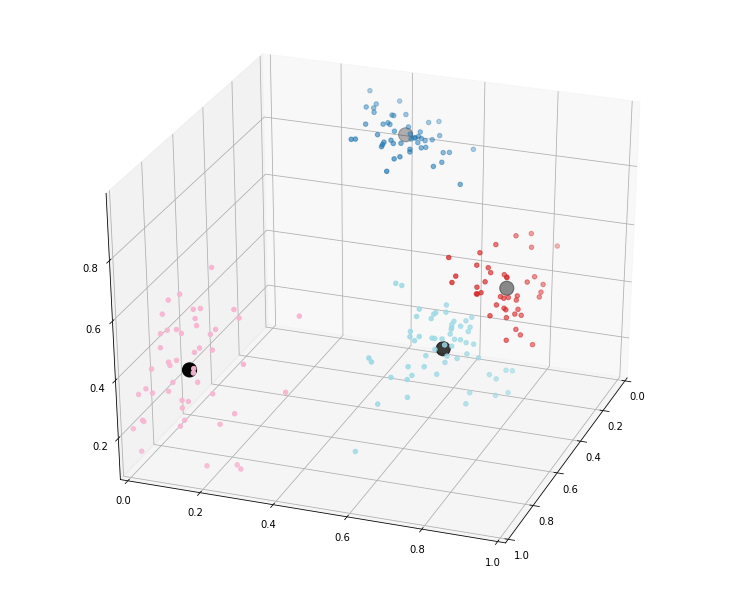

In [11]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)
ax.scatter(*data, c = labels, cmap = "tab20")
ax.scatter(*centroids, c = "black", s = 200)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.view_init(30, 20)

## Geometric mean distance (exact)

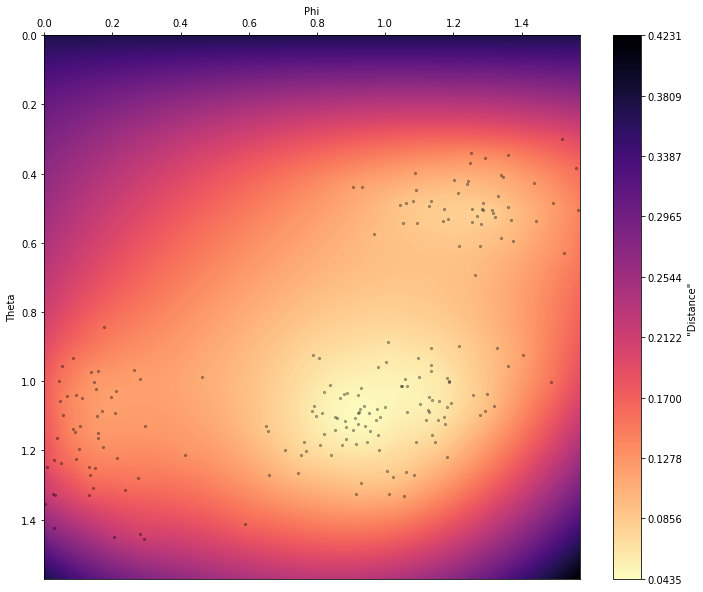

In [12]:
make_2D_plot(Phi, Theta, D_geo_raw)

## Geometric mean distance (approximate)

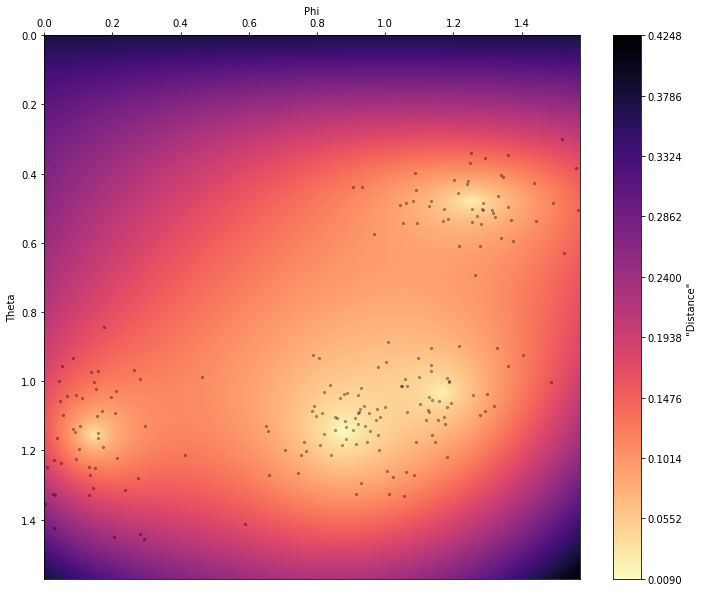

In [13]:
make_2D_plot(Phi, Theta, D_geo)

##  Minimum distance (exact)

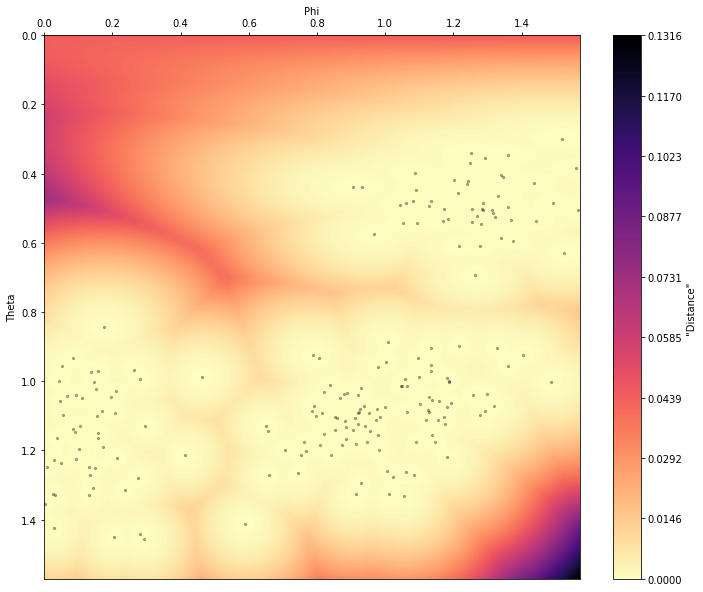

In [14]:
make_2D_plot(Phi, Theta, D_min_raw)

## Minimum distance (approximate)

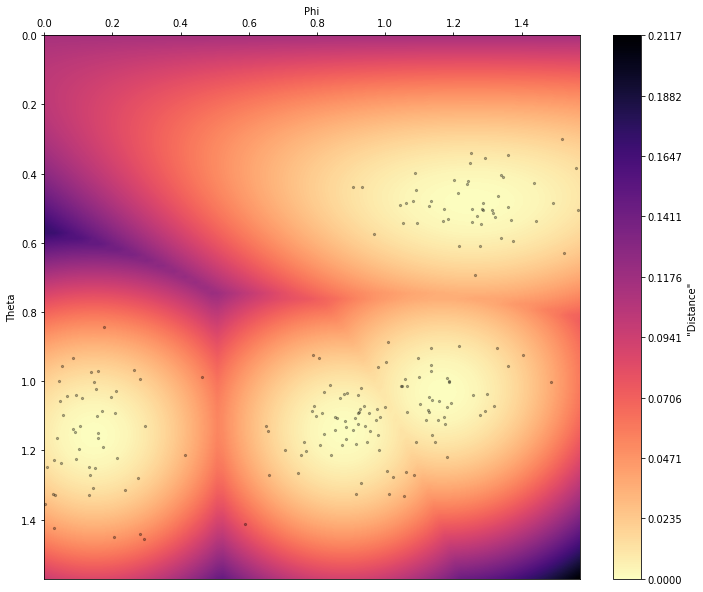

In [15]:
make_2D_plot(Phi, Theta, D_min)

## Arithmetic mean distance (exact)

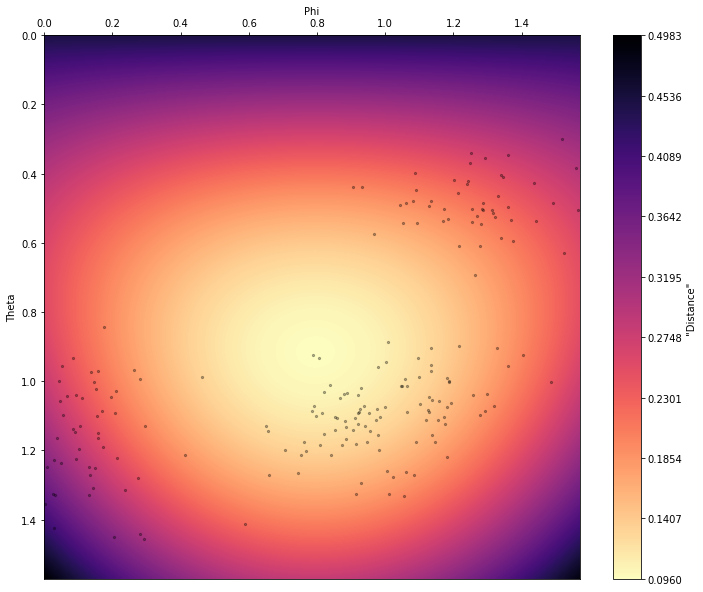

In [16]:
make_2D_plot(Phi, Theta, D_arith_raw)

## Arithmetic mean distance (approximate)

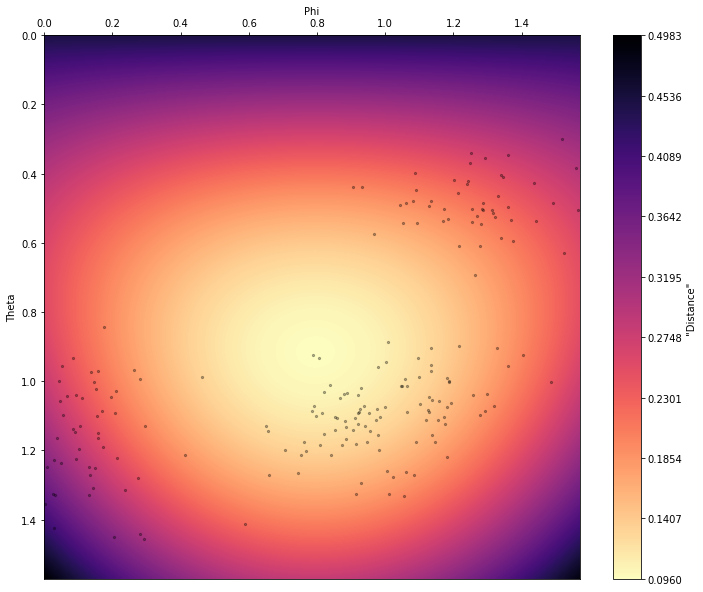

In [17]:
make_2D_plot(Phi, Theta, D_arith)